In [380]:
#Import some necessary packages
import pandas as pd
import numpy as np
import itertools as it
import time
import matplotlib.pyplot as plt

In [337]:
#Load in the data fromt the excel sheet (placed in the same directory)
meterDf=pd.read_excel('gorilla_test_data.xlsx','meter_list')
forecastDf=pd.read_excel('gorilla_test_data.xlsx','forecast_table')
rateDf=pd.read_excel('gorilla_test_data.xlsx','rate_table')

1. Use pandas to calculate a transportation distribution charge for four gas meters in
the United Kingdom. Save your code in a Jupyter notebook and upload to a public
repo on Github (or any other platform of your choice). While solving this exercise,
focus on efficiency - i.e., use vectorised operations and avoid loops! All data
needed for the calculation can be found in the Excel file for this exercise.

In [358]:
#Construct the dataframe for question 1. The total can be done with a simple groupby and sum, the other question requires some more work
resultDf=pd.DataFrame(columns=['Meter ID','Total Estimated Consumption (kWh)','Total Cost (£)'])
metersTot=forecastDf.groupby('meter_id')['kwh'].sum()
resultDf['Meter ID']=metersTot.index
resultDf['Total Estimated Consumption (kWh)']=metersTot.values
#Construct some helper dataframes that clear up the code
tempRateDf=rateDf.merge(meterDf,on='exit_zone')
#Conversion to float was done to prevent some weird errors
tempRateDf.loc[:,['aq_min_kwh','aq_kwh']]=tempRateDf[['aq_min_kwh','aq_kwh']].astype('float')
#Select the rows rates that are relevant to the specific meter
tempRateDf=tempRateDf[(tempRateDf['aq_min_kwh'] <= tempRateDf['aq_kwh']) & ((tempRateDf['aq_max_kwh'] > tempRateDf['aq_kwh']) | pd.isnull(tempRateDf['aq_max_kwh']))]
tempForecastDf=forecastDf.merge(tempRateDf,on=['meter_id','date'],how='outer')
tempForecastDf=tempForecastDf.sort_values('date')
#Kind of long, could use a separate line to define the mask. Basically, select the rows of the original forecast and the rows before the first date to get the correct rates, then forward fill
tempDf = tempForecastDf[(tempForecastDf['kwh'].notnull()) | (tempForecastDf['date'] < min(tempForecastDf.loc[tempForecastDf['kwh'].notnull(), 'date']))].groupby(['meter_id'],as_index=False).apply(lambda x : x.ffill())
tempDf = tempDf[tempDf['kwh'].notnull()].reset_index(drop=True)
tempDf['cost in pounds']=totDf['kwh']*tempDf['rate_p_per_kwh']/100
costGb=tempDf.groupby('meter_id')['cost in pounds'].sum().sort_index()
resultDf=resultDf.sort_values('Meter ID')
resultDf['Total Cost (£)']=costGb.values.round(2)

2. Write a function that generates a list of random meters of any size. Examples of valid
exit zones can be found in the rate table. You may randomly generate the annual
quantity.

In [82]:
def generateMeters(n):
    resDf=pd.DataFrame(columns=['meter_id','aq_kwh','exit_zone'])
    #Assuming meters have an 8-digit code
    resDf['meter_id']=np.random.randint(10000000,99999999,size=n)
    resDf['aq_kwh']=np.random.uniform(min(meterDf['aq_kwh'])*0.5,max(meterDf['aq_kwh'])*1.5,size=n).round(2)
    #A list of similar exit zones could be generated instead of type AA1
    resDf['exit_zone']=rateDf['exit_zone'].sample(n).values
    return resDf

3. Write a function that generates mock consumption data given a list of meters and a
start date and duration (number of days in the forecast). The data may be completely
random and it doesn't have to match with the meters' annual quantities either.

In [368]:
def generateConsumptionData(meters,startDate,duration):
    #This assumes meters is a list and not a dataframe. To pass a dataframe to this, simply replace meters by meters['meter_id']
    dates=pd.date_range(start=startDate,periods=duration,freq='d')
    resDf=pd.DataFrame(it.product(meters,dates),columns=['meter_id','date'])
    resDf['kwh']=np.random.uniform(min(forecastDf['kwh']*0.5)*0.5,max(forecastDf['kwh']*1.5)*1.5,size=len(resDf)).round(2)
    return resDf

4. Write a function that takes as an input a meter list and a consumption forecast table
and that calculates the transportation cost table (i.e., best take your logic from task 1
and wrap it in a function). Benchmark this function using meter lists of different sizes
and consumption forecasts for periods of different lengths. How does the function scale
for larger sets of data?

In [374]:
def calcTransportCost(meters,forecast):
    resultDf=pd.DataFrame(columns=['Meter ID','Total Estimated Consumption (kWh)','Total Cost (£)'])
    metersTot=forecast.groupby('meter_id')['kwh'].sum()
    resultDf['Meter ID']=metersTot.index
    resultDf['Total Estimated Consumption (kWh)']=metersTot.values
    #Construct some helper dataframes that clear up the code
    tempRateDf=rateDf.merge(meters,on='exit_zone')
    #Conversion to float was done to prevent some weird errors
    tempRateDf.loc[:,['aq_min_kwh','aq_kwh']]=tempRateDf[['aq_min_kwh','aq_kwh']].astype('float')
    #Select the rows rates that are relevant to the specific meter
    tempRateDf=tempRateDf[(tempRateDf['aq_min_kwh'] <= tempRateDf['aq_kwh']) & ((tempRateDf['aq_max_kwh'] > tempRateDf['aq_kwh']) | pd.isnull(tempRateDf['aq_max_kwh']))]
    tempForecastDf=forecast.merge(tempRateDf,on=['meter_id','date'],how='outer')
    tempForecastDf=tempForecastDf.sort_values('date')
    #Kind of long, could use a separate line to define the mask. Basically, select the rows of the original forecast and the rows before the first date to get the correct rates, then forward fill
    tempDf = tempForecastDf[(tempForecastDf['kwh'].notnull()) | (tempForecastDf['date'] < min(tempForecastDf.loc[tempForecastDf['kwh'].notnull(), 'date']))].groupby(['meter_id'],as_index=False).apply(lambda x : x.ffill())
    tempDf = tempDf[tempDf['kwh'].notnull()].reset_index(drop=True)
    tempDf['cost in pounds']=tempDf['kwh']*tempDf['rate_p_per_kwh']/100
    costGb=tempDf.groupby('meter_id')['cost in pounds'].sum().sort_index()
    resultDf=resultDf.sort_values('Meter ID')
    resultDf['Total Cost (£)']=costGb.values.round(2)
    return resultDf

In [424]:
#Benchmark the length of the forecast  at a constant number of meters
metersN=10
resForecastLs=[]
for dur in range(100,500):
    meters=generateMeters(metersN)
    forecast=generateConsumptionData(meters['meter_id'],"2020-06-01",dur)
    timeStart=time.time()
    calcTransportCost(meters,forecast)
    timeDur=time.time()-timeStart
    resForecastLs.append(timeDur)

Text(0, 0.5, 'Execution time (in s)')

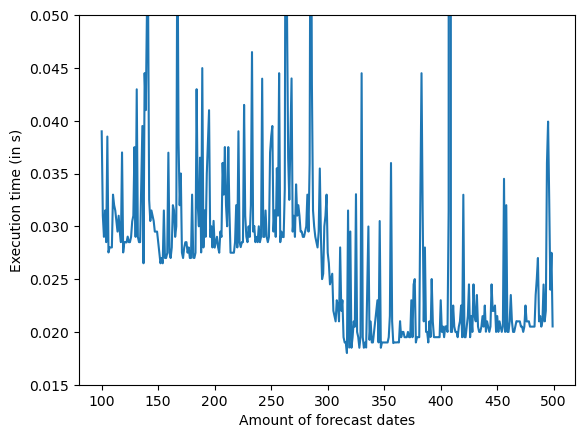

In [426]:
plt.plot(range(100,500),resForecastLs)
plt.ylim(0.015,0.05)
plt.xlabel("Amount of forecast dates")
plt.ylabel("Execution time (in s)")

In [430]:
#Benchmark the number of meters  at a constant number of length of the forecast
dur=300
resMetersLs=[]
for metersN in range(1,200):
    meters=generateMeters(metersN)
    forecast=generateConsumptionData(meters['meter_id'],"2020-06-01",dur)
    timeStart=time.time()
    calcTransportCost(meters,forecast)
    timeDur=time.time()-timeStart
    resMetersLs.append(timeDur)

Text(0, 0.5, 'Execution time (in s)')

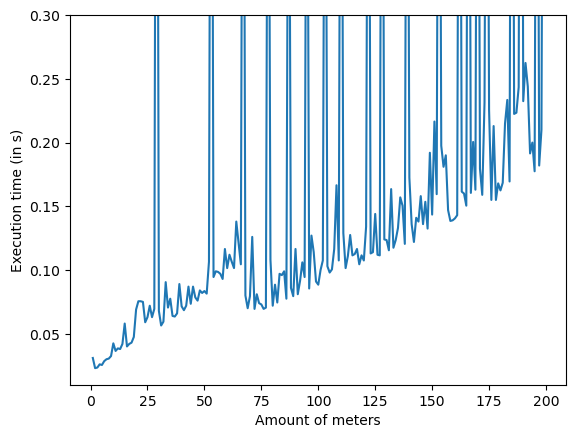

In [431]:
plt.plot(range(1,200),resMetersLs)
plt.ylim(0.01,0.3)
plt.xlabel("Amount of meters")
plt.ylabel("Execution time (in s)")

5. What are your observations after benchmarking? Are there any steps in the cost
calculation that can be improved? How would you go about improving the performance
of this calculation?

While the amount of meters changes at an expected rate (with some outliers, but they are not at constant values so the are simple machine flukes) of a longer time for more meters, the length of the forecast in particular exhibits some strange behaviour. 

The time the function needs increases linearly with more meters. There is some strange behaviour around 60 meters, where the execution time drops, after which it increases again. 
With less than 300 days, the time required is about constant with a very small increase but that is almost neglegible compared to variance. After 300 days, the execution time drops, after which it very slowly rises again. I don't see an immediate explanation for this behaviour.

There could very well be some improvements in the calculation of the transportation table, but this is the fastest way I could find that works. The benchmarking itself could also be optimized as it uses a for loop instead of vectorized calculation, but in this case, this is not as easy to implement. Perhaps scikit-learn could provide a solution for this, but right now, implementing another benchmark strategy would probably take longer than benchmarking the current way.